In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_grid(imgs, titles, rows, cols, figsize):
    fig, axs = plt.subplots(rows, cols, figsize=figsize) # Cria um grid para as imgs
    for a, i, t in zip(axs.flatten(), imgs, titles):
        # Adiciona uma imagem (i) na posição correta (a):
        a.imshow(i, cmap='gray', aspect='equal', interpolation=None, vmin=0, vmax=255)
        a.set_title(t)
    # Desativa o eixo das imagens (separado pois o número de imgs pode não preencher o grid):
    for a in axs.flatten(): a.set_axis_off()

    plt.tight_layout()
    plt.show()
    return fig, axs

In [3]:
from skimage.util import img_as_ubyte
baboon = io.imread('./baboon.png')
butterfly = io.imread('./butterfly.png')
city = io.imread('./city.png')
house = io.imread('./house.png')
seagull = io.imread('./seagull.png')
poly = img_as_ubyte(io.imread('./poly.png', as_gray=True)).astype(float)
imgs = [baboon, butterfly, city, house, seagull, poly]

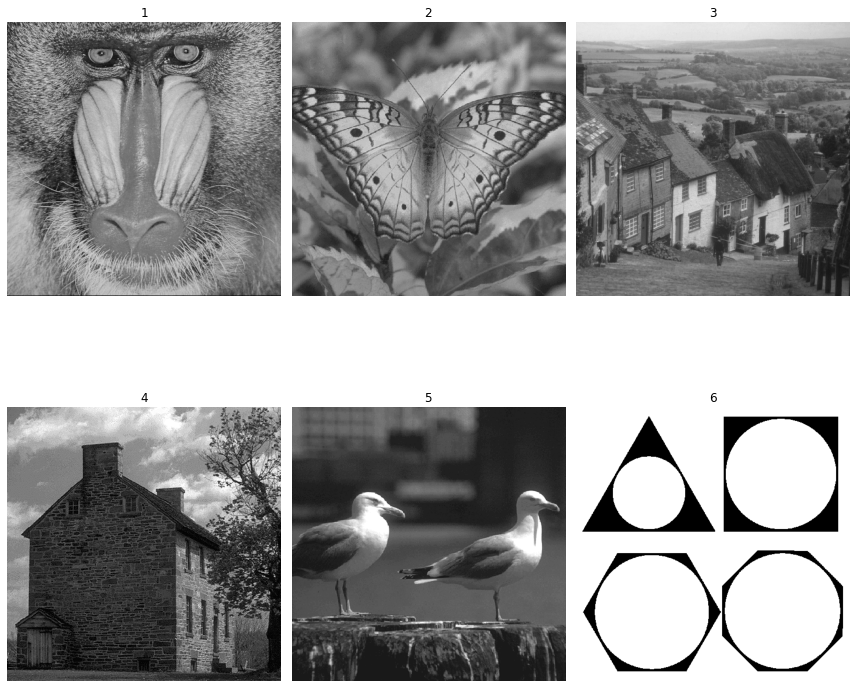

In [4]:
f1, axs1 = plot_grid(imgs, range(1, 7), 2, 3, (12, 12))

In [5]:
from math import floor
from functools import partial


# Creates a rotaion matrix arround a center with negative angles (indirect):
def rot_mat(theta, x_center, y_center):
    theta = theta * np.pi / 180  # converts to radians
    
    # Translation matrizes used to move the center of rotation:
    # note that they are switched because the mapping is indirect
    mov_mat = np.array(((1, 0, -x_center), (0, 1, -y_center), (0, 0, 1)))
    mov_mat_prime = np.array(((1, 0, x_center), (0, 1, y_center), (0, 0, 1)))

    # Rotation matrix around the origion:
    cos, sin = np.cos(-theta), np.sin(-theta)
    rot = np.array(((cos, -sin, 0), (sin, cos, 0), (0, 0, 1)))
    
    return mov_mat_prime @ rot @ mov_mat  # compose the matrizes


# Creates a scaling matrix with inverse factors (indirect):
def scl_mat(x_factor, y_factor):
    return np.array(((1 / x_factor, 0, 0), (0, 1 / y_factor, 0), (0, 0, 1)))


def closest(f, x, y, w, h):
    x = round(x); y = round(y)
    if x >= 0 and x < w and y >= 0 and y < h:
        return f[x][y]
    return 0


def bilinear(f, x, y, w, h):
    xf, yf = floor(x), floor(y)  # gets the upper left corner
    if xf >= 1 and xf < w - 1 and yf >= 1 and yf < h - 1:  # border values are ignored
        dx, dy = x - xf, y - yf
        return (1-dx)*(1-dy)*f[xf][yf] + dx*(1-dy)*f[xf+1][yf] +\
            (1-dx)*dy*f[xf][yf+1] + dx*dy*f[xf+1][yf+1]
    return 0


P = lambda t: max(0, t)
def R(s):
    return 1/6 * (P(s+2)**3 - 4*P(s+1)**3 + 6*P(s)**3 - 4*P(s-1)**3)


def bicubic(f, x, y, w, h):
    xf, yf = floor(x), floor(y)  # gets the upper left corner
    if xf >= 1 and xf < w - 2 and yf >= 1 and yf < h - 2:  # border values are ignored
        dx, dy = x - xf, y - yf
        ret = 0
        for m in range(-1, 3):
            for n in range(-1, 3):
                ret += f[xf + m][yf + n] * R(m - dx) * R(dy - n)
        return ret
    return 0


def L(f, dx, dy, x, y, n):
    return 1/2*(-dx*(dx-1)*(dx-2)*f[x-1][y+n-2]/3 + (dx+1)*(dx-1)*(dx-2)*f[x][y+n-2] +\
               -dx*(dx+1)*(dx-2)*f[x+1][y+n-2] + dx*(dx+1)*(dx-1)*f[x+2][y+n-2]/3)


def lagrange(f, x, y, w, h):
    xf, yf = floor(x), floor(y)  # gets the upper left corner
    if xf >= 1 and xf < w - 2 and yf >= 1 and yf < h - 2:  # border values are ignored
        dx, dy = x - xf, y - yf
        L_curried = partial(L, f, dx, dy)
        return 1/2*(-dy*(dy-1)*(dy-2)*L_curried(xf, yf, 1)/3 + (dy+1)*(dy-1)*(dy-2)*L_curried(xf, yf, 2) +\
                    -dy*(dy+1)*(dy-2)*L_curried(xf, yf, 3)   + dy*(dy+1)*(dy-1)*L_curried(xf, yf, 4)/3)
    return 0
    
# The mapping is indirect to prevent blank regions:
def indirect_mapping(in_img, out_img, f_prime, method):
    w, h = in_img.shape
    w_prime, h_prime = out_img.shape
    for x_prime in range(w_prime):
        for y_prime in range(h_prime):
            pos_prime = np.array((x_prime, y_prime, 1))
            x, y, _ = f_prime @ pos_prime  # P = f'P'
            out_img[x_prime][y_prime] = method(in_img, x, y, w, h)

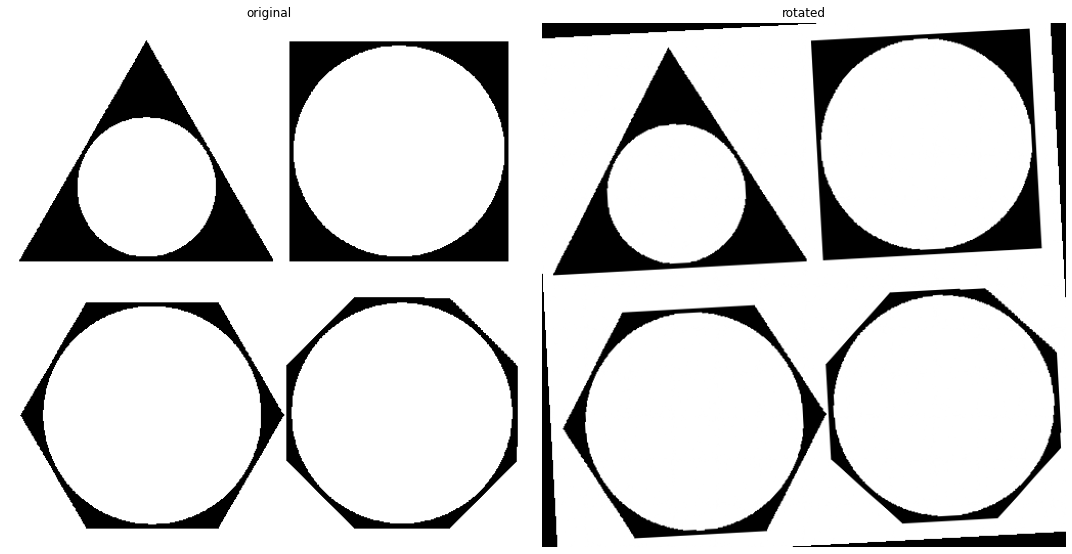

In [6]:
a, b = poly.shape
rot_m = rot_mat(np.pi, a/2, b/2)
rot_poly = np.empty(poly.shape, dtype=int)
indirect_mapping(poly, rot_poly, rot_m, lagrange)
f2, axs2 = plot_grid([poly, rot_poly], ['original', 'rotated'], 1, 2, (15, 15))